In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import packages

In [2]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.data import AUTOTUNE
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy


# Data preprocessing

## data_dir path

In [3]:
data_dir = Path("/content/drive/MyDrive/CS338_NhanDang/grocery-images")
data_dir

PosixPath('/content/drive/MyDrive/CS338_NhanDang/grocery-images')

In [4]:
n_train =  len(list((data_dir/"train").glob("*/*.jpg")))
n_val = len(list((data_dir/"val").glob("*/*.jpg")))
n_test = len(list((data_dir/"test").glob("*/*.jpg")))

print("train:", n_train)
print("val:", n_val)
print("test:", n_test)

train: 434
val: 124
test: 62


## Configure batch_size

In [5]:
batch_size = 16
img_height = 224
img_width = img_height
img_size = (img_height, img_width)
img_shape = img_size + (3, )

In [6]:
train_ds = preprocessing.image_dataset_from_directory(
    data_dir/"train",
    seed=5555,
    image_size=img_size,
    batch_size=batch_size,
    smart_resize=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir/"val",
    seed=55555,
    image_size=img_size,
    smart_resize=True,
    batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir/"test",
    seed=55555,
    image_size=img_size,
    smart_resize=True,
    batch_size=batch_size)

Found 434 files belonging to 62 classes.
Found 124 files belonging to 62 classes.
Found 62 files belonging to 62 classes.


In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(num_classes, class_names)

62 ['bánh gạo An', 'bánh oreo original', 'bánh quế kem vị cam cosy', 'bình nước khoáng bidrico', 'bình nước khoáng tachiwa', 'bình nước khoáng vĩnh hảo', 'bột canh vifon', 'bột cà ri', 'bột ngũ vị hương', 'bùi nhùi thép', 'bút bi xanh', 'cafe sữa đá (cafe phố - MacCoffee)', 'cafe sữa đá (nescafe 3 in 1)', 'cafe đen đá nescafe', 'chai nước khoáng aquafina 5 lít', 'cháo gói thịt bằm gấu đỏ', 'cháo tổ yến thịt bằm', 'cơm cháy chà bông', 'hủ tiếu nam vang cung đình', 'keo 502', 'keo hai mặt', 'kẹo 4 mùa', 'kẹo DoubleMint', 'kẹo mentos golia', 'kẹo mút con gấu', 'kẹo mút sữa milkita', 'kẹo singum lql hình xăm', 'khẩu trang y tế', 'mắm ruốc trí hải', 'miến vị sườn heo phú hương (gói ăn liền)', 'mirinda soda kem', 'mì chay vị nấm miliket', 'mì giấy (mì tôm)', 'mì gói gấu đỏ', 'mì gói lẩu nấm chua cay reeva', 'mì gói lẩu thái tôm acecook', 'mì gói tô

## Visualize dataset

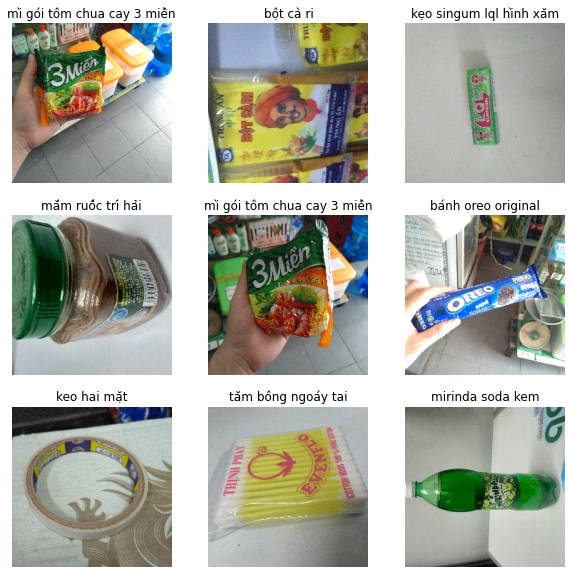

In [8]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

## Configure the dataset for performance

In [9]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

# MobileNetV3Small

## Model construction

In [10]:
v3_small = MobileNetV3Small(input_shape=img_shape,
                              include_top=False)

In [11]:
v3_small.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [12]:
v3_small.trainable = False

augment = models.Sequential([
	layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
	layers.experimental.preprocessing.RandomZoom(
		height_factor=(-0.05, -0.15),
		width_factor=(-0.05, -0.15)),
	layers.experimental.preprocessing.RandomRotation(0.3)
])


inputs = layers.Input(shape=img_shape)
x = augment(inputs)
x = v3_small(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x) 
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3small (Functional (None, 7, 7, 1024)        1529968   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 62)                15934 

## Train the model

In [14]:
initial_epoch = 40
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                              restore_best_weights=True)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [15]:
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=initial_epoch, callbacks=[stop_early])

Epoch 1/40
28/28 [==============================] - 80s 2s/step - loss: 4.2753 - accuracy: 0.0484 - val_loss: 3.7886 - val_accuracy: 0.1290
Epoch 2/40
28/28 [==============================] - 1s 21ms/step - loss: 3.3931 - accuracy: 0.2051 - val_loss: 3.2324 - val_accuracy: 0.2500
Epoch 3/40
28/28 [==============================] - 1s 18ms/step - loss: 2.6617 - accuracy: 0.3548 - val_loss: 2.5908 - val_accuracy: 0.4355
Epoch 4/40
28/28 [==============================] - 1s 19ms/step - loss: 2.0257 - accuracy: 0.5046 - val_loss: 2.2709 - val_accuracy: 0.5000
Epoch 5/40
28/28 [==============================] - 1s 18ms/step - loss: 1.6003 - accuracy: 0.6267 - val_loss: 1.8409 - val_accuracy: 0.5806
Epoch 6/40
28/28 [==============================] - 1s 18ms/step - loss: 1.2137 - accuracy: 0.7166 - val_loss: 1.5777 - val_accuracy: 0.5968
Epoch 7/40
28/28 [==============================] - 1s 19ms/step - loss: 0.9891 - accuracy: 0.7650 - val_loss: 1.4506 - val_accuracy: 0.6452
Epoch 8/40
28/

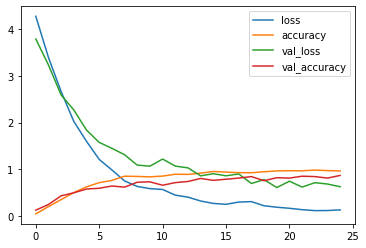

In [17]:
pd.DataFrame(history.history).plot()

## Fine-tunning

In [18]:
pip install -q -U keras-tuner

In [19]:
import keras_tuner as kt

In [20]:
def build_model(base_model, hp):
  base_model.trainable = False

  augment = models.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomZoom(
      height_factor=(-0.05, -0.15),
      width_factor=(-0.05, -0.15)),
    layers.experimental.preprocessing.RandomRotation(0.3)
  ])


  inputs = layers.Input(shape=img_shape)
  x = augment(inputs)
  x = base_model(x, training=False)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.2)(x) 
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  x = layers.Dense(hp_units, activation="relu")(x)
  outputs = layers.Dense(num_classes, activation="softmax")(x)

  model = models.Model(inputs, outputs)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=optimizers.Adam(hp_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])
  return model

Hyperband determines the number of models to train in a bracket by computing 1 + logfactor(max_epochs) and rounding it up to the nearest integer.

In [21]:
tuner = kt.Hyperband(lambda hp: build_model(v3_small, hp),
                    objective='val_accuracy',
                    max_epochs=10,
                    factor=3,
                    directory='my_dir',
                    project_name='optimal_hyperparameter_1'
                    )
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                              restore_best_weights=True)
tuner.search(train_ds, epochs=50, validation_data=val_ds, callbacks=[stop_early])

Trial 30 Complete [00h 00m 16s]
val_accuracy: 0.41129031777381897

Best val_accuracy So Far: 0.6209677457809448
Total elapsed time: 00h 04m 24s
INFO:tensorflow:Oracle triggered exit


In [22]:
best_hps=tuner.get_best_hyperparameters()[0]
best_hps['learning_rate'], best_hps['units']

(0.001, 448)

In [23]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=initial_epoch)

Epoch 1/40
28/28 [==============================] - 5s 52ms/step - loss: 4.5063 - accuracy: 0.0323 - val_loss: 3.7056 - val_accuracy: 0.1855
Epoch 2/40
28/28 [==============================] - 1s 20ms/step - loss: 3.3219 - accuracy: 0.2189 - val_loss: 2.9339 - val_accuracy: 0.3468
Epoch 3/40
28/28 [==============================] - 1s 19ms/step - loss: 2.4270 - accuracy: 0.4194 - val_loss: 2.3278 - val_accuracy: 0.4194
Epoch 4/40
28/28 [==============================] - 1s 19ms/step - loss: 1.7676 - accuracy: 0.5968 - val_loss: 1.9368 - val_accuracy: 0.5161
Epoch 5/40
28/28 [==============================] - 1s 19ms/step - loss: 1.3551 - accuracy: 0.6613 - val_loss: 1.6022 - val_accuracy: 0.6129
Epoch 6/40
28/28 [==============================] - 1s 19ms/step - loss: 1.0257 - accuracy: 0.7465 - val_loss: 1.5329 - val_accuracy: 0.6048
Epoch 7/40
28/28 [==============================] - 1s 18ms/step - loss: 0.8734 - accuracy: 0.8226 - val_loss: 1.4326 - val_accuracy: 0.5968
Epoch 8/40
28

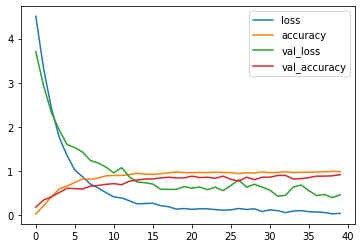

In [24]:
pd.DataFrame(history.history).plot()

## Save Model

In [25]:
saved_dir = "/content/drive/MyDrive/CS338_NhanDang"

In [26]:
model.save(os.path.join(saved_dir, 'small'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/CS338_NhanDang/small/assets


# MobileNetV3 Small Minimalistic

In [27]:
v3_small_minimalistic = MobileNetV3Small(input_shape=img_shape, minimalistic=True, 
                                         include_top=False)
tuner = kt.Hyperband(lambda hp: build_model(v3_small_minimalistic, hp),
                    objective='val_accuracy',
                    max_epochs=10,
                    factor=3,
                    directory='my_dir',
                    project_name='optimal_hyperparameter_2'
                    )
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                              restore_best_weights=True)
tuner.search(train_ds, epochs=50, validation_data=val_ds, callbacks=[stop_early])

Trial 30 Complete [00h 00m 06s]
val_accuracy: 0.016129031777381897

Best val_accuracy So Far: 0.6854838728904724
Total elapsed time: 00h 02m 47s
INFO:tensorflow:Oracle triggered exit


In [28]:
best_hps=tuner.get_best_hyperparameters()[0]
best_hps['learning_rate'], best_hps['units']

(0.001, 480)

In [29]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=initial_epoch, callbacks=[stop_early])

Epoch 1/40
28/28 [==============================] - 3s 35ms/step - loss: 4.7230 - accuracy: 0.0346 - val_loss: 3.9928 - val_accuracy: 0.0565
Epoch 2/40
28/28 [==============================] - 0s 15ms/step - loss: 3.7973 - accuracy: 0.1129 - val_loss: 3.4274 - val_accuracy: 0.2177
Epoch 3/40
28/28 [==============================] - 0s 14ms/step - loss: 3.2231 - accuracy: 0.2373 - val_loss: 3.1824 - val_accuracy: 0.2903
Epoch 4/40
28/28 [==============================] - 0s 14ms/step - loss: 2.6529 - accuracy: 0.3756 - val_loss: 2.7913 - val_accuracy: 0.3790
Epoch 5/40
28/28 [==============================] - 0s 13ms/step - loss: 2.2009 - accuracy: 0.4977 - val_loss: 2.3989 - val_accuracy: 0.4919
Epoch 6/40
28/28 [==============================] - 0s 14ms/step - loss: 1.8627 - accuracy: 0.5668 - val_loss: 1.9892 - val_accuracy: 0.5565
Epoch 7/40
28/28 [==============================] - 0s 14ms/step - loss: 1.5509 - accuracy: 0.6544 - val_loss: 1.6640 - val_accuracy: 0.5968
Epoch 8/40
28

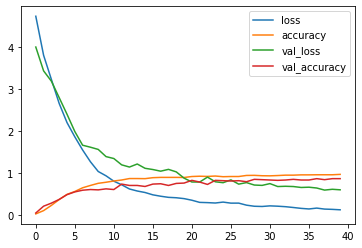

In [30]:
pd.DataFrame(history.history).plot()

In [31]:
model.save(os.path.join(saved_dir, 'small_minimalistic'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/CS338_NhanDang/small_minimalistic/assets


# MobileNetV3Large

In [32]:
v3_large = MobileNetV3Large(input_shape=img_shape, include_top=False)
tuner = kt.Hyperband(lambda hp: build_model(v3_large, hp),
                    objective='val_accuracy',
                    max_epochs=10,
                    factor=3,
                    directory='my_dir',
                    project_name='optimal_hyperparameter_3'
                    )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                              restore_best_weights=True)
tuner.search(train_ds, epochs=50, validation_data=val_ds, callbacks=[stop_early])

Trial 30 Complete [00h 00m 16s]
val_accuracy: 0.04032257944345474

Best val_accuracy So Far: 0.8225806355476379
Total elapsed time: 00h 05m 25s
INFO:tensorflow:Oracle triggered exit


In [33]:
best_hps=tuner.get_best_hyperparameters()[0]
best_hps['learning_rate'], best_hps['units']

(0.001, 480)

In [34]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=initial_epoch, callbacks=[stop_early])

Epoch 1/40
28/28 [==============================] - 5s 67ms/step - loss: 4.2673 - accuracy: 0.0829 - val_loss: 3.4329 - val_accuracy: 0.1532
Epoch 2/40
28/28 [==============================] - 1s 28ms/step - loss: 2.6615 - accuracy: 0.3571 - val_loss: 2.4974 - val_accuracy: 0.4274
Epoch 3/40
28/28 [==============================] - 1s 28ms/step - loss: 1.6595 - accuracy: 0.6060 - val_loss: 1.9640 - val_accuracy: 0.5323
Epoch 4/40
28/28 [==============================] - 1s 29ms/step - loss: 1.1479 - accuracy: 0.7189 - val_loss: 1.5846 - val_accuracy: 0.6048
Epoch 5/40
28/28 [==============================] - 1s 29ms/step - loss: 0.7671 - accuracy: 0.8018 - val_loss: 1.3794 - val_accuracy: 0.6048
Epoch 6/40
28/28 [==============================] - 1s 28ms/step - loss: 0.5835 - accuracy: 0.8594 - val_loss: 1.0032 - val_accuracy: 0.7823
Epoch 7/40
28/28 [==============================] - 1s 28ms/step - loss: 0.4304 - accuracy: 0.8917 - val_loss: 0.9336 - val_accuracy: 0.7984
Epoch 8/40
28

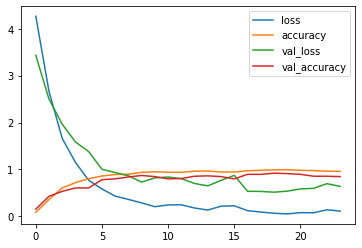

In [35]:
pd.DataFrame(history.history).plot()

In [36]:
model.save(os.path.join(saved_dir, 'large'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/CS338_NhanDang/large/assets


# MobileNetV3 Large Minimalistic

In [37]:
v3_large_minimalistic = MobileNetV3Large(input_shape=img_shape, minimalistic=True, 
                                         include_top=False)
tuner = kt.Hyperband(lambda hp: build_model(v3_large_minimalistic, hp),
                    objective='val_accuracy',
                    max_epochs=10,
                    factor=3,
                    directory='my_dir',
                    project_name='optimal_hyperparameter_4'
                    )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                              restore_best_weights=True)
tuner.search(train_ds, epochs=50, validation_data=val_ds, callbacks=[stop_early])

Trial 30 Complete [00h 00m 11s]
val_accuracy: 0.024193547666072845

Best val_accuracy So Far: 0.5887096524238586
Total elapsed time: 00h 04m 09s
INFO:tensorflow:Oracle triggered exit


In [38]:
best_hps=tuner.get_best_hyperparameters()[0]
best_hps['learning_rate'], best_hps['units']

(0.0001, 480)

In [39]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=initial_epoch, callbacks=[stop_early])

Epoch 1/40
28/28 [==============================] - 4s 48ms/step - loss: 4.3745 - accuracy: 0.0184 - val_loss: 3.9760 - val_accuracy: 0.0645
Epoch 2/40
28/28 [==============================] - 1s 22ms/step - loss: 4.0342 - accuracy: 0.0576 - val_loss: 3.8000 - val_accuracy: 0.1129
Epoch 3/40
28/28 [==============================] - 1s 22ms/step - loss: 3.7921 - accuracy: 0.1037 - val_loss: 3.6210 - val_accuracy: 0.1855
Epoch 4/40
28/28 [==============================] - 1s 21ms/step - loss: 3.5682 - accuracy: 0.1820 - val_loss: 3.4033 - val_accuracy: 0.2742
Epoch 5/40
28/28 [==============================] - 1s 22ms/step - loss: 3.3893 - accuracy: 0.2143 - val_loss: 3.2127 - val_accuracy: 0.3226
Epoch 6/40
28/28 [==============================] - 1s 21ms/step - loss: 3.1687 - accuracy: 0.2903 - val_loss: 3.0296 - val_accuracy: 0.3952
Epoch 7/40
28/28 [==============================] - 1s 21ms/step - loss: 2.9676 - accuracy: 0.3479 - val_loss: 2.8251 - val_accuracy: 0.4839
Epoch 8/40
28

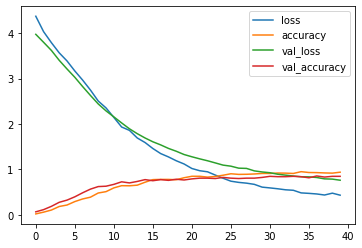

In [40]:
pd.DataFrame(history.history).plot()

In [41]:
model.save(os.path.join(saved_dir, 'large_minimalistic'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/CS338_NhanDang/large_minimalistic/assets


# Evaluation

In [42]:
model = models.load_model(os.path.join(saved_dir, 'large'))

In [43]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

4/4 [==============================] - 11s 195ms/step - loss: 0.5705 - accuracy: 0.8387
Test accuracy : 0.8387096524238586
